In [1]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

In [2]:
# 策略继承CtaTemplate
class MultiKlineStrategy(CtaTemplate):
    className = 'MultiKlineStrategy'
    author = 'howers'
    # 策略参数
    trailingPct = 0.16  
    KlinePct = 0.7
    lot = 1
    # 策略变量 
    candle40= {};candle20= {}
    candle15= {}
    transactionPrice = {} # 记录成交价格
    # 参数列表，保存了参数的名称
    paramList = [
                 'trailingPct','KlinePct'
                ]    
    # 变量列表，保存了变量的名称
    varList = [
               'candle40','candle20',
               'candle15',
               'transactionPrice'
              ]  
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']
    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.candle40 = {s:0 for s in self.symbolList}
        self.candle20 = {s:0 for s in self.symbolList}
        self.candle15 = {s:0 for s in self.symbolList}
        self.intraTradeHighDict = {s: 0 for s in self.symbolList}
        self.intraTradeLowDict = {s: 999999 for s in self.symbolList}
        self.putEvent()
    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        # 计算止损止盈价位
        # 变量初始化
        if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999
        # 持有多头仓位
        elif self.posDict[symbol + "_LONG"] > 0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            longStop = self.intraTradeHighDict[symbol] * (1-self.trailingPct)
            if bar.low <= longStop:
#                 print('longStop')
                self.cancelAll()
                self.sell(symbol, bar.close * 0.99, self.posDict[symbol + "_LONG"])
        # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            shortStop = self.intraTradeLowDict[symbol] * (1 + self.trailingPct)
            if bar.high >= shortStop:
#                 print('shortStop')
                self.cancelAll()
                self.cover(symbol, bar.close * 1.01, self.posDict[symbol + "_SHORT"])
    #----------------------------------------------------------------------
    def on40MinBar(self, bar):
        """收到40MinBar推送"""
        symbol = bar.vtSymbol
        am40 = self.getArrayManager(symbol, "40m")
        if not am40.inited:
            return
        # 计算均线并判断趋势
        lowlead = ((min(am40.close[-1],am40.open[-1])-am40.low[-1])/(am40.high[-1]-am40.low[-1]))>self.KlinePct 
        toplead = ((am40.high[-1]-max(am40.close[-1],am40.open[-1]))/(am40.high[-1]-am40.low[-1]))>self.KlinePct  
        
        
        #定义事件信号
        if lowlead:
            self.candle40[symbol] = -100 
        elif toplead:
            self.candle40[symbol] = 100 
    #----------------------------------------------------------------------
    def on20MinBar(self, bar):
        """收到20MinBar推送"""
        symbol = bar.vtSymbol
        am20 = self.getArrayManager(symbol, "20m")
        if not am20.inited:
            return
        
        kicking = ta.CDLKICKING(am20.open, am20.high, am20.low, am20.close)
        kickgbylength = ta.CDLKICKINGBYLENGTH(am20.open, am20.high, am20.low, am20.close) 
        
        self.candle20[symbol]=-4*kicking-4*kickgbylength
        #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        am15 = self.getArrayManager(symbol, "15m")
        if not am15.inited:
            return
        
        threeoutside= ta.CDL3OUTSIDE(am15.open, am15.high, am15.low, am15.close) 
        sanwhitesolders = ta.CDL3WHITESOLDIERS(am15.open, am15.high, am15.low, am15.close) 
        eveningdojistar=ta.CDLEVENINGDOJISTAR(am15.open, am15.high, am15.low, am15.close, penetration=0) 
        stalledpattern = ta.CDLSTALLEDPATTERN(am15.open, am15.high, am15.low, am15.close)  
        sticksandwich = ta.CDLSTICKSANDWICH(am15.open, am15.high, am15.low, am15.close)
        tasukigap = ta. CDLTASUKIGAP(am15.open, am15.high, am15.low, am15.close) 
        tristar= ta.CDLTRISTAR(am15.open, am15.high, am15.low, am15.close) 
        unique3rever=ta.CDLUNIQUE3RIVER(am15.open, am15.high, am15.low, am15.close)
        xsidegap3methods = ta.CDLXSIDEGAP3METHODS(am15.open, am15.high, am15.low, am15.close)
        
        
        
        self.candle15[symbol]=-threeoutside+sanwhitesolders-eveningdojistar-stalledpattern+sticksandwich-tasukigap-unique3rever-xsidegap3methods-tristar
        
        Signal=self.candle15[symbol]+self.candle40[symbol]+self.candle20[symbol]
        
        if (Signal[-1]>=200) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        if (Signal[-1]<=-200) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
            print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [3]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy import BacktestingEngine
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
    engine.setStartDate('20180115 12:00',initHours=200) # 设置回测用的数据起始日期
    engine.setEndDate('20181201 12:00') # 设置回测用的数据终止日期
    # 配置回测引擎参数
    engine.setSlippage(0.002)    # 设置滑点
    engine.setRate(5/10000)   # 设置手续费千1
    engine.setCapital(1000000)  # 设置回测本金
    # # 在引擎中创建策略对象
    parameterDict = {'symbolList':['BTCUSDT:binance']}          # 策略参数配置
    engine.initStrategy(MultiKlineStrategy, parameterDict)    # 创建策略对象
    engine.runBacktesting()
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_40Min_bar函数functools.partial(<function MultiKlineStrategy.on40MinBar at 0x000002B1C7C28158>, <__main__.MultiKlineStrategy object at 0x000002B1C7BFEC50>)
[DEBUG] 注册品种BTCUSDT:binance上的on_20Min_bar函数functools.partial(<function MultiKlineStrategy.on20MinBar at 0x000002B1C7C28048>, <__main__.MultiKlineStrategy object at 0x000002B1C7BFEC50>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiKlineStrategy.on15MinBar at 0x000002B1C7C281E0>, <__main__.MultiKlineStrategy object at 0x000002B1C7BFEC50>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiKlineStrategy.onBar at 0x000002B1C7C280D0>, <__main__.MultiKlineStrategy object at 0x000002B1C7BFEC50>)
2018-12-19 20:22:06.289069	开始回测
2018-12-19 20:22:06.289069	策略初始化
2018-12-19 20:22:06.291071	载入历史数据。数据范围:[20180107 04:00,20180115 12:00)
2018-12-19 20:22:08.396408	 当前品种 BTCUSDT:binance 的数据，全部来自于本地

Traceback (most recent call last):
  File "D:\Users\Administrator\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "D:\Users\Administrator\Anaconda3\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史40mK线更新，范围为:[20180112172000 , 20180115112000]
[INFO] 品种BTCUSDT:binance开始生成未完成的20mK线数据,时间起点为:20180115120000
[INFO] 品种BTCUSDT:binance的历史20mK线更新，范围为:[20180114024000 , 20180115114000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180115120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180114110000 , 20180115114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180115120100
[INFO] 品种BTCUSDT:binance开始生成40mK线数据,时间起点为:20180115120000
[INFO] 品种BTCUSDT:binance开始生成20mK线数据,时间起点为:20180115120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180115120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 13367.0, 'high': 13484.629999999999, 'low': 13338.21, 'close': 13460.0, 'date': '20180115', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 1, 15, 12, 0), 'volume': 94.180292999999992, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180114111500 , 20180115120000]
[

2018-04-29 07:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-04-29 15:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-05-02 00:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-05-02 21:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-05-03 18:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-05-04 11:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-05-05 14:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-05-06 16:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-05-07 05:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-05-07 22:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-05-08 21:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-05-09 19:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
2018-05-10 19:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
2018-05-12 0

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-11-30 05:15:00,多,,,0.0,,开仓,513,,4201.51,0.0,None,,,513,2018-11-30 05:15:00,1,513,BTCUSDT:binance,513
2018-11-30 07:15:00,空,,,0.0,,平仓,514,,4305.06,0.0,None,,,514,2018-11-30 07:15:00,1,514,BTCUSDT:binance,514
2018-11-30 07:15:00,空,,,0.0,,开仓,515,,4305.06,0.0,None,,,515,2018-11-30 07:15:00,1,515,BTCUSDT:binance,515
2018-12-01 11:00:00,多,,,0.0,,平仓,516,,4020.00,0.0,None,,,516,2018-12-01 11:00:00,1,516,BTCUSDT:binance,516
2018-12-01 11:00:00,多,,,0.0,,开仓,517,,4020.00,0.0,None,,,517,2018-12-01 11:00:00,1,517,BTCUSDT:binance,517


2018-12-19 20:23:37.112254	计算按日统计结果
2018-12-19 20:23:37.522529	------------------------------
2018-12-19 20:23:37.523530	首个交易日：	2018-01-15 00:00:00
2018-12-19 20:23:37.523530	最后交易日：	2018-12-01 00:00:00
2018-12-19 20:23:37.523530	总交易日：	321
2018-12-19 20:23:37.523530	盈利交易日	175
2018-12-19 20:23:37.523530	亏损交易日：	144
2018-12-19 20:23:37.523530	起始资金：	1000000
2018-12-19 20:23:37.523530	结束资金：	1,017,460.12
2018-12-19 20:23:37.523530	总收益率：	1.75%
2018-12-19 20:23:37.523530	年化收益：	1.31%
2018-12-19 20:23:37.523530	总盈亏：	17,460.12
2018-12-19 20:23:37.523530	最大回撤: 	-2,414.06
2018-12-19 20:23:37.523530	百分比最大回撤: -0.24%
2018-12-19 20:23:37.523530	总手续费：	1,973.71
2018-12-19 20:23:37.523530	总滑点：	1.03
2018-12-19 20:23:37.523530	总成交金额：	3,947,410.72
2018-12-19 20:23:37.523530	总成交笔数：	517
2018-12-19 20:23:37.523530	日均盈亏：	54.39
2018-12-19 20:23:37.523530	日均手续费：	6.15
2018-12-19 20:23:37.523530	日均滑点：	0.0
2018-12-19 20:23:37.523530	日均成交金额：	12,297.23
2018-12-19 20:23:37.523530	日均成交笔数：	1.61
2018-12-19 20:23:37.523530	日

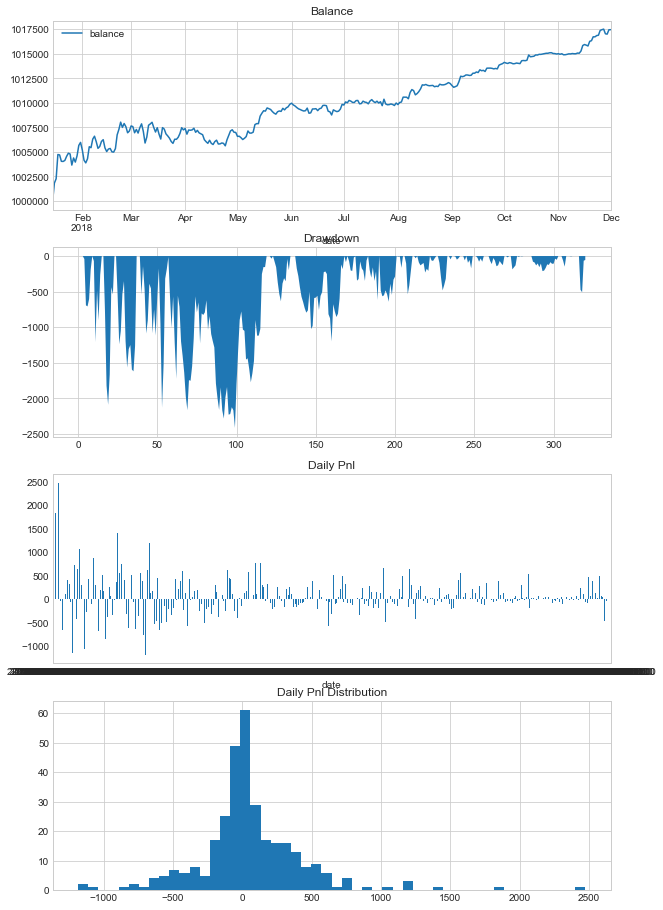

In [4]:
engine.showDailyResult()

2018-12-19 20:24:08.415571	计算回测结果
2018-12-19 20:24:08.447593	------------------------------
2018-12-19 20:24:08.447593	第一笔交易：	2018-01-17 06:39:00
2018-12-19 20:24:08.447593	最后一笔交易：	2018-12-01 11:58:00
2018-12-19 20:24:08.447593	总交易次数：	259
2018-12-19 20:24:08.447593	总盈亏：	17,458.11
2018-12-19 20:24:08.448593	最大回撤: 	-2,458.86
2018-12-19 20:24:08.449594	平均每笔盈利：	67.41
2018-12-19 20:24:08.449594	平均每笔滑点：	0.0
2018-12-19 20:24:08.450595	平均每笔佣金：	7.63
2018-12-19 20:24:08.450595	胜率		55.6%
2018-12-19 20:24:08.450595	盈利交易平均值	298.06
2018-12-19 20:24:08.450595	亏损交易平均值	-221.41
2018-12-19 20:24:08.450595	盈亏比：	1.35


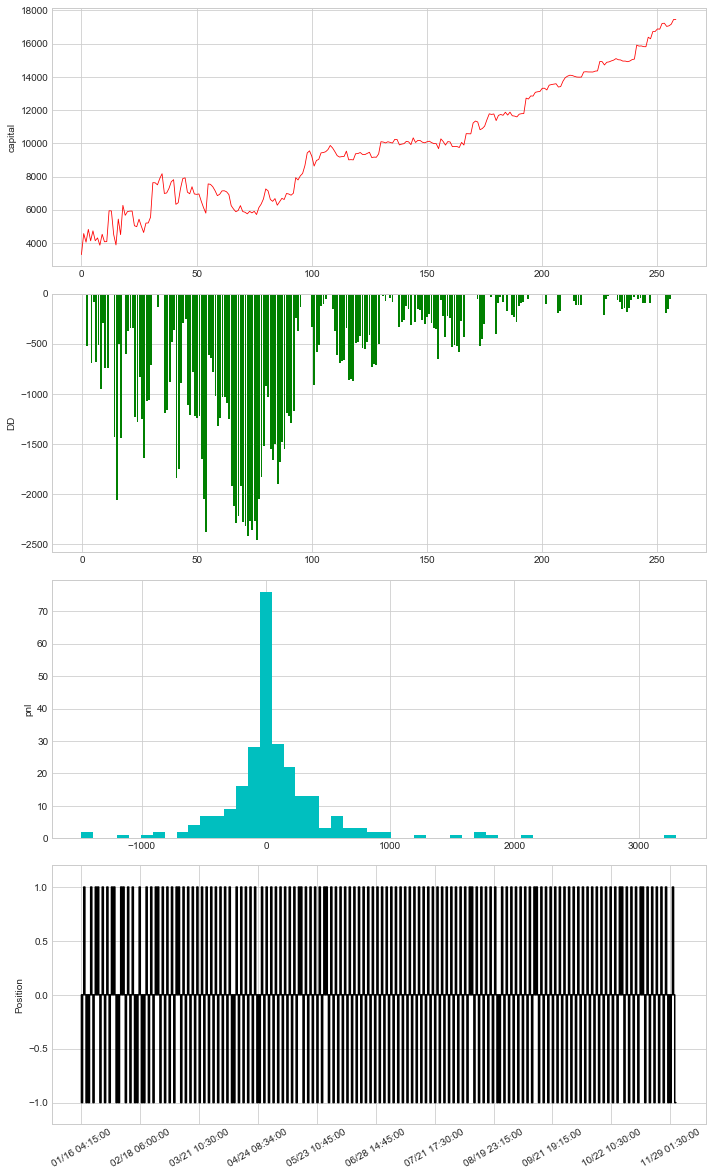

In [5]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [6]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)
print(pd.Series(result))

2018-12-19 13:13:31.729336	计算按日统计结果
annualizedReturn                1.30543
dailyCommission                 6.14861
dailyNetPnl                     54.3929
dailyReturn                  0.00539235
dailySlippage                0.00322118
dailyTradeCount                 1.61059
dailyTurnover                   12297.2
endBalance                  1.01746e+06
endDate             2018-12-01 00:00:00
lossDays                            144
maxDdPercent                  -0.239481
maxDrawdown                    -2414.06
profitDays                          175
returnStd                     0.0375257
sharpeRatio                     2.22615
startDate           2018-01-15 00:00:00
totalCommission                 1973.71
totalDays                           321
totalNetPnl                     17460.1
totalReturn                     1.74601
totalSlippage                     1.034
totalTradeCount                     517
totalTurnover               3.94741e+06
dtype: object
